In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 895 kB 65.0 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 48.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


文件目录；需要新建data文件夹，文件夹下新建cluener,将数据拖放在文件下


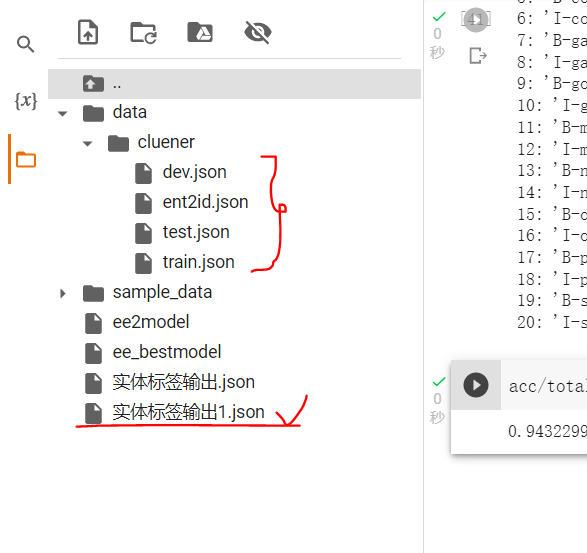

In [2]:
import json
import os
from collections import Counter

import numpy as np

from transformers import BertModel, BertTokenizer,BertTokenizerFast
import torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm


In [32]:
"""
Date: 2021-06-01 17:18:25
LastEditors: GodK
"""
import time

common = {
    "exp_name": "cluener",
    "encoder": "BERT",
    "data_home": "data",
    "bert_path": "./pretrained_models/bert-base-chinese",  # bert-base-cased， bert-base-chinese
    "run_type": "train",  # train,eval
    "f1_2_save": 0.5,  # 存模型的最低f1值
    "logger": "default"  # wandb or default，default意味着只输出日志到控制台
}

# wandb的配置，只有在logger=wandb时生效。用于可视化训练过程
wandb_config = {
    "run_name": time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime()),
    "log_interval": 10
}

train_config = {
    "train_data": "train.json",
    "valid_data": "dev.json",
    "test_data": "test.json",
    "ent2id": "ent2id.json",
    "path_to_save_model": "./outputs",  # 在logger不是wandb时生效
    "hyper_parameters": {
        "lr": 5e-5,
        "batch_size": 1,
        "epochs": 8,
        "seed": 2333,
        "max_seq_len": 128,
        "scheduler": "CAWR"
    }
}

eval_config = {
    "model_state_dir": "./outputs/cluener/",  # 预测时注意填写模型路径（时间tag文件夹）
    "run_id": "",
    "last_k_model": 1,  # 取倒数第几个model_state
    "test_data": "test.json",
    "ent2id": "ent2id.json",
    "save_res_dir": "./results",
    "hyper_parameters": {
        "batch_size": 16,
        "max_seq_len": 512,
    }

}

cawr_scheduler = {
    # CosineAnnealingWarmRestarts
    "T_mult": 1,
    "rewarm_epoch_num": 2,
}
step_scheduler = {
    # StepLR
    "decay_rate": 0.999,
    "decay_steps": 100,
}

# ---------------------------------------------
train_config["hyper_parameters"].update(**cawr_scheduler, **step_scheduler)
train_config = {**train_config, **common, **wandb_config}
eval_config = {**eval_config, **common}


In [4]:
model_name='bert-base-chinese'
seq_length=128
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [5]:
def load_data(data_path, data_type="train"):
    """读取数据集

    Args:
        data_path (str): 数据存放路径
        data_type (str, optional): 数据类型. Defaults to "train".

    Returns:
        (json): train和valid中一条数据格式：{"text":"","entity_list":[(start, end, label), (start, end, label)...]}
    """
    if data_type == "train" or data_type == "valid":
        # datas = []
        # with open(data_path, encoding="utf-8") as f:
        #     for line in f:
        #         line = json.loads(line)
        #         item = {}
        #         item["text"] = line["text"]
        #         item["entity_list"] = []
        #         for k, v in line['label'].items():
        #             for spans in v.values():
        #                 for start, end in spans:
        #                     item["entity_list"].append((start, end, k))
        #
        #         datas.append(item)
        datas = []
        with open(data_path, encoding="utf-8") as f:
            for line in f.readlines():
                line = json.loads(line)
                item = {}
                item["text"] = line["text"]
                item["entity_list"] = []
                for k, v in line['label'].items():
                    for k_, span in v.items():
                        for spans in span:
                            item["entity_list"].append((spans[0], spans[1], k))

                datas.append(item)
        return datas
    else:
        return json.load(open(data_path, encoding="utf-8"))

def find_head_idx(source, target):
    target_len = len(target)
    for i in range(len(source)):
        if source[i: i + target_len] == target:
            return i,i + target_len-1
    return -1,-1

In [6]:
# entity2id={"O":0,"address": 1, "book": 2, "company": 3, "game": 4, "government": 5, "movie": 6, "name": 7, "organization": 8, "position": 9, "scene": 10}

BERT_MAX_LEN = 128

In [7]:
entity2id={
    "O":0,
"B-address": 1, "I-address": 2,
"B-book": 3,"I-book": 4,
"B-company": 5,"I-company": 6,
"B-game": 7, "I-game":8,
"B-government": 9, "I-government": 10,
    "B-movie": 11, "I-movie": 12,
    "B-name": 13, "I-name": 14,
    "B-organization": 15,"I-organization": 16,
    "B-position": 17, "I-position": 18,
    "B-scene": 19,"I-scene": 20
}

In [8]:
class Preprocessor(object):
    def __init__(self, tokenizer):
        super(Preprocessor, self).__init__()
        self.tokenizer = tokenizer
        self.add_special_tokens = True

    def get_ent2token_spans(self, text, entity_list):
        """实体列表转为token_spans

        Args:
            text (str): 原始文本
            entity_list (list): [(start, end, ent_type),(start, end, ent_type)...]
        """
        ent2token_spans = []

        inputs = self.tokenizer(text, add_special_tokens=True, return_offsets_mapping=True)
        token2char_span_mapping = inputs["offset_mapping"]
        text2tokens = self.tokenizer.tokenize(text, add_special_tokens=self.add_special_tokens)

        for ent_span in entity_list:
            ent = text[ent_span[0]:ent_span[1] + 1]
            ent2token = self.tokenizer.tokenize(ent, add_special_tokens=False)

            # 寻找ent的token_span
            token_start_indexs = [i for i, v in enumerate(text2tokens) if v == ent2token[0]]

            token_end_indexs = [i for i, v in enumerate(text2tokens) if v == ent2token[-1]]

            token_start_index = list(filter(lambda x: token2char_span_mapping[x][0] == ent_span[0], token_start_indexs))
            token_end_index = list(filter(lambda x: token2char_span_mapping[x][-1] - 1 == ent_span[1], token_end_indexs))  # token2char_span_mapping[x][-1]-1 减1是因为原始的char_span是闭区间，而token2char_span是开区间

            if len(token_start_index) == 0 or len(token_end_index) == 0:
                # print(f'[{ent}] 无法对应到 [{text}] 的token_span，已丢弃')
                continue
            token_span = (token_start_index[0], token_end_index[0], ent_span[2])
            ent2token_spans.append(token_span)

        return ent2token_spans

In [9]:
class data_generator:
    def __init__(self, data, tokenizer, maxlen):
        self.data = data
        self.batch_size = len(self.data)
        self.tokenizer = tokenizer
        self.maxlen = maxlen
        self.preprocessor = Preprocessor(tokenizer)

    def __len__(self):
        return self.batch_size

    def generator(self):
        # while True:
        # idxs = list(range(len(self.data)))
        sent_lengths = []
        tokens_batch, segments_batch, token_type_batch, labels_ids = [], [], [], []
        start_indexs = []
        end_indexs = []
        # tokens_batch--------tokens ids;segments_batch-------attention mask; token_type_ids--------；labels_ids------ 每个实体的label标签
        for sample in self.data:

            text_len = BERT_MAX_LEN
            inputs = self.tokenizer(sample['text'], return_tensors='pt', add_special_tokens=True, truncation=True, padding=True,
                                    max_length=BERT_MAX_LEN)
            token_ids, segment_ids, token_type_ids = inputs['input_ids'], inputs['attention_mask'], inputs[
                'token_type_ids']

            sent_lengths.append(token_ids.shape[1])
            pad_len = BERT_MAX_LEN - token_ids.shape[1]
            pad_seq = torch.zeros(1, pad_len)
            token_ids = torch.cat((token_ids, pad_seq), dim=1)
            segment_ids = torch.cat((segment_ids, pad_seq), dim=1)
            token_type_ids = torch.cat((token_type_ids, pad_seq), dim=1)
            #句子的label标签
            labels=torch.zeros(self.maxlen)
            ent2token_spans = self.preprocessor.get_ent2token_spans(
                sample["text"], sample["entity_list"]
            )
            for start, end, label in ent2token_spans:
                labels[start]=entity2id['B-'+label]
                if start+1!=end+1:
                    labels[start+1:end+1]=entity2id['I-'+label]

            labels_ids.append(labels)
            token_type_batch.append(token_type_ids)
            tokens_batch.append(token_ids)
            segments_batch.append(segment_ids)

            # print(sub_heads,sub_tails,torch.where(obj_heads==1),torch.where(obj_tails)==1)
        return tokens_batch, segments_batch, token_type_batch, labels_ids,sent_lengths

In [33]:
if True:
    train_path=os.path.join(common["data_home"], common["exp_name"], train_config["train_data"])
    train_data = load_data(train_path)
    print('train_data_length',len(train_data))
    train_config=train_config
    maxlen = train_config["hyper_parameters"]['max_seq_len']
    train_tokens_batch, train_segments_batch, train_token_type_batch, train_labels_ids,train_length = \
        data_generator(train_data,tokenizer,maxlen).generator()

    vaild_path=os.path.join(common["data_home"], common["exp_name"], train_config["valid_data"])
    vaild_data=load_data(vaild_path)
    print('valid_data_length',len(vaild_data))
    test_path=os.path.join(common["data_home"], common["exp_name"], train_config["test_data"])
    test_data=load_data(test_path)
    vaild_tokens_batch, vaild_segments_batch, vaild_token_type_batch, valid_labels_ids ,valid_length= \
        data_generator(vaild_data, tokenizer, maxlen).generator()

    test_tokens_batch, test_segments_batch, test_token_type_batch, test_labels_ids ,test_length= \
        data_generator(test_data, tokenizer, maxlen).generator()
sign=['train_','valid_','test_']
for di in sign:
    if di == 'train_':
        tokens_batch, segments_batch, token_type_batch, labels_ids = train_tokens_batch, train_segments_batch, train_token_type_batch, train_labels_ids
        tokens_batch = torch.cat([l for l in tokens_batch]).int()
        print(tokens_batch.shape)
        segments_batch = torch.cat([l for l in segments_batch]).int()  # sents_length*128
        # 命名实体识别

        token_type_batch = torch.cat([l for l in token_type_batch]).int()
        labels_ids_batch = torch.cat([l for l in labels_ids]).reshape(tokens_batch.shape[0], -1).int()
        train_dataset=TensorDataset(tokens_batch,segments_batch,token_type_batch,labels_ids_batch)

    elif di=='valid_':
        tokens_batch, segments_batch, token_type_batch, labels_ids =  vaild_tokens_batch, vaild_segments_batch, vaild_token_type_batch, valid_labels_ids
        tokens_batch = torch.cat([l for l in tokens_batch]).int()
        print(tokens_batch.shape)
        segments_batch = torch.cat([l for l in segments_batch]).int()  # sents_length*128
        # 命名实体识别

        token_type_batch = torch.cat([l for l in token_type_batch]).int()
        labels_ids_batch = torch.cat([l for l in labels_ids]).reshape(tokens_batch.shape[0], -1).int()
        valid_dataset=TensorDataset(tokens_batch,segments_batch,token_type_batch,labels_ids_batch)

    elif di=='test_':
        tokens_batch, segments_batch, token_type_batch, labels_ids,sent_lengths = test_tokens_batch, test_segments_batch, test_token_type_batch, test_labels_ids,test_length
        tokens_batch = torch.cat([l for l in tokens_batch]).int()
        print(tokens_batch.shape)
        segments_batch = torch.cat([l for l in segments_batch]).int()  # sents_length*128
        # 命名实体识别
        sent_lengths_batch = torch.tensor(sent_lengths).reshape(tokens_batch.shape[0], -1).int()
        token_type_batch = torch.cat([l for l in token_type_batch]).int()
        labels_ids_batch = torch.cat([l for l in labels_ids]).reshape(tokens_batch.shape[0], -1).int()
        test_dataset = TensorDataset(tokens_batch, segments_batch, token_type_batch, labels_ids_batch,sent_lengths_batch)

print('train_dataset_length',len(train_dataset))
print('vaild_dataset_length',len(valid_dataset))
print('test_dataset_length',len(test_dataset))

train_data_length 10748
valid_data_length 843
torch.Size([10748, 128])
torch.Size([843, 128])
torch.Size([500, 128])
train_dataset_length 10748
vaild_dataset_length 843
test_dataset_length 500


In [29]:
test_data[:2]

[{'entity_list': [(7, 8, 'address'), (2, 4, 'name')],
  'text': '甚至朱自清都对西山有过描述。另外就是山林的感觉。'},
 {'entity_list': [(0, 6, 'game')], 'text': '《龙与地下城》影响业界'}]

## data generator

In [12]:
!pip install pytorch-crf

In [13]:
from transformers import AdamW
from transformers import BertModel
from torch.nn import functional as F


## model

In [14]:
import torch.nn as nn
loss_fun = nn.CrossEntropyLoss()
class E2EModel(nn.Module):
    def __init__(self):
        super(E2EModel, self).__init__()
        self.tagset_size=len(entity2id.keys())
        self.hidden_dim=768
        self.encode=BertModel.from_pretrained(model_name)
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
        #                     num_layers=1, bidirectional=True)
        # self.classifier1 = nn.Linear(768, 128)
        # # Maps the output of the LSTM into tag space.
        # self.classifier2 = nn.Linear(128, self.tagset_size)
        self.classifier2=nn.Linear(768, self.tagset_size)


    def forward(self,inputs_id,att_mask,token_type_ids,labels_ids):
        bo=self.encode(inputs_id,att_mask,token_type_ids)[0]#B*L*768
        # x=x.view(128, -1, 768)

        # x=self.classifier1(bo)
        # # x=x.view(128, hidden_dim)
        # categories_numberic=self.classifier2(x)
        categories_numberic=self.classifier2(bo)
        categories_numberic=categories_numberic.reshape(-1,self.tagset_size)
        return categories_numberic  #

In [15]:
def same_seeds(seed):
    # torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
same_seeds(0)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.optim.lr_scheduler import LambdaLR
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)


In [17]:
def train(eenet, train_dataset, val_set, num_epochs, learning_rate, batch_size):
    i = 1
    model_path = 'model'
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
    print('执行次数为：{}'.format(i))
    t_total = len(train_loader) * num_epochs
    # warmup_steps = int(t_total * warmup_proportion)
    warmup_steps = 50
    optimizer = AdamW(eenet.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=t_total)

    eenet = eenet.to(device)

    # tokens_batch[:rc_train_size], segments_batch[:rc_train_size], token_type_batch[:rc_train_size], labels_ids_batch[:rc_train_size], sub_batch_tags[:rc_train_size], obj_batch_tags[:rc_train_size]
    for epoch in range(num_epochs):
        eenet.train()
        train_loss = 0.
        step = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            torch.autograd.set_detect_anomaly(True)

            inputs_id, att_mask, token_type_ids, labels_ids = data
            text, mask, token_type_ids, labels_ids = inputs_id.to(device), att_mask.to(device), token_type_ids.to(
                device), labels_ids.to(device)
            optimizer.zero_grad()
            targets = labels_ids.view(-1).to(torch.int64)
            # print(targets.shape)
            # ee _model识别实体----------------------------------------------
            soutputs = eenet(text, mask, token_type_ids, labels_ids)
            # print(soutputs.shape)
            s_loss =loss_fun(soutputs, targets)
            # 准备一个batch(batch_size=1)的训练数据

            # ee_type model 识别实体类型-----------------------------------------------
            t_loss = s_loss
            t_loss.backward()
            # all_loss.backward()
            train_loss += t_loss.item()
            optimizer.step()
            scheduler.step()
            step += 1

            if step % 100 == 0:
                print('\n')
                print('*' * 10)
                print(
                    'train_epoch|{},average_loss={}'.format(epoch + 1,  train_loss / step))

        torch.save(eenet.state_dict(), 'ee2' + model_path)

        eenet.eval()
        min_loss = 1
        with torch.no_grad():
            val_loss = 0.
            val_step = 0
            vaild_loader = DataLoader(val_set, batch_size=batch_size)
            for batch_idx, data in enumerate(tqdm(vaild_loader)):

                inputs_id, att_mask, token_type_ids, labels_ids = data
                text, mask, token_type_ids, labels_ids = inputs_id.to(device), att_mask.to(device), token_type_ids.to(
                    device), labels_ids.to(device)
                targets =  labels_ids.view(-1).to(torch.int64)
                # ee _model识别实体----------------------------------------------
                soutputs = eenet(text, mask, token_type_ids, labels_ids)
                s_loss= loss_fun(soutputs, targets)

                # all_loss.backward()
                val_loss += s_loss.item()

                val_step += 1

                if val_step % 50 == 0:
                    print('\n')
                    print('-' * 10)
                    print(
                        'val_epoch|{},val_averge_loss={}'.format(epoch + 1, val_loss / val_step))

            if val_loss < min_loss:
                min_loss = val_loss
                print('save model')
                torch.save(eenet.state_dict(), 'ee_best' + model_path)



In [18]:
eenet=E2EModel()
train(eenet,train_dataset, valid_dataset,20, 1e-5, 32)

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

执行次数为：1


 30%|██▉       | 100/336 [01:00<02:27,  1.60it/s]



**********
train_epoch|1,average_loss=0.8943581216037273


 60%|█████▉    | 200/336 [01:59<01:20,  1.68it/s]



**********
train_epoch|1,average_loss=0.5529305136948824


 89%|████████▉ | 300/336 [02:58<00:21,  1.70it/s]



**********
train_epoch|1,average_loss=0.4083828128625949


100%|██████████| 11/11 [00:01<00:00,  8.04it/s]


save model


 30%|██▉       | 100/336 [00:58<02:17,  1.71it/s]



**********
train_epoch|2,average_loss=0.08087295614182949


 60%|█████▉    | 200/336 [01:57<01:19,  1.71it/s]



**********
train_epoch|2,average_loss=0.07633908599615097


 89%|████████▉ | 300/336 [02:56<00:21,  1.71it/s]



**********
train_epoch|2,average_loss=0.07106962742904822


100%|██████████| 11/11 [00:01<00:00,  8.02it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.70it/s]



**********
train_epoch|3,average_loss=0.05538621712476015


 60%|█████▉    | 200/336 [01:57<01:19,  1.72it/s]



**********
train_epoch|3,average_loss=0.05439607972279191


 89%|████████▉ | 300/336 [02:56<00:20,  1.72it/s]



**********
train_epoch|3,average_loss=0.052531569780160985


100%|██████████| 11/11 [00:01<00:00,  8.06it/s]


save model


 30%|██▉       | 100/336 [00:58<02:17,  1.71it/s]



**********
train_epoch|4,average_loss=0.04547551902011037


 60%|█████▉    | 200/336 [01:57<01:19,  1.71it/s]



**********
train_epoch|4,average_loss=0.04494387382641435


 89%|████████▉ | 300/336 [02:55<00:20,  1.72it/s]



**********
train_epoch|4,average_loss=0.043478444113085664


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.70it/s]



**********
train_epoch|5,average_loss=0.038733088169246914


 60%|█████▉    | 200/336 [01:57<01:19,  1.72it/s]



**********
train_epoch|5,average_loss=0.03808973314706236


 89%|████████▉ | 300/336 [02:56<00:21,  1.70it/s]



**********
train_epoch|5,average_loss=0.0369781596865505


100%|██████████| 11/11 [00:01<00:00,  8.00it/s]


save model


 30%|██▉       | 100/336 [00:58<02:17,  1.72it/s]



**********
train_epoch|6,average_loss=0.03451689653098583


 60%|█████▉    | 200/336 [01:57<01:19,  1.70it/s]



**********
train_epoch|6,average_loss=0.03369938977994025


 89%|████████▉ | 300/336 [02:55<00:20,  1.71it/s]



**********
train_epoch|6,average_loss=0.03269241401304801


100%|██████████| 11/11 [00:01<00:00,  8.04it/s]


save model


 30%|██▉       | 100/336 [00:58<02:17,  1.71it/s]



**********
train_epoch|7,average_loss=0.030258083092048763


 60%|█████▉    | 200/336 [01:57<01:20,  1.69it/s]



**********
train_epoch|7,average_loss=0.029797350307926535


 89%|████████▉ | 300/336 [02:56<00:21,  1.71it/s]



**********
train_epoch|7,average_loss=0.02881921108812094


100%|██████████| 11/11 [00:01<00:00,  8.00it/s]


save model


 30%|██▉       | 100/336 [00:59<02:18,  1.70it/s]



**********
train_epoch|8,average_loss=0.02715156491845846


 60%|█████▉    | 200/336 [01:58<01:20,  1.69it/s]



**********
train_epoch|8,average_loss=0.026247818083502353


 89%|████████▉ | 300/336 [02:57<00:21,  1.69it/s]



**********
train_epoch|8,average_loss=0.025198210591139893


100%|██████████| 11/11 [00:01<00:00,  8.03it/s]


save model


 30%|██▉       | 100/336 [00:59<02:36,  1.51it/s]



**********
train_epoch|9,average_loss=0.024204798555001617


 60%|█████▉    | 200/336 [01:58<01:19,  1.71it/s]



**********
train_epoch|9,average_loss=0.023774720625951887


 89%|████████▉ | 300/336 [02:57<00:21,  1.70it/s]



**********
train_epoch|9,average_loss=0.02296760892495513


100%|██████████| 11/11 [00:01<00:00,  8.02it/s]


save model


 30%|██▉       | 100/336 [00:59<02:18,  1.71it/s]



**********
train_epoch|10,average_loss=0.02190036709420383


 60%|█████▉    | 200/336 [01:58<01:20,  1.69it/s]



**********
train_epoch|10,average_loss=0.021115425422322004


 89%|████████▉ | 300/336 [02:57<00:21,  1.64it/s]



**********
train_epoch|10,average_loss=0.02012173109843085


100%|██████████| 11/11 [00:01<00:00,  8.01it/s]


save model


 30%|██▉       | 100/336 [00:59<02:19,  1.70it/s]



**********
train_epoch|11,average_loss=0.020032249675132334


 60%|█████▉    | 200/336 [01:58<01:20,  1.69it/s]



**********
train_epoch|11,average_loss=0.019379331183154137


 89%|████████▉ | 300/336 [02:57<00:21,  1.71it/s]



**********
train_epoch|11,average_loss=0.018448145425257582


100%|██████████| 11/11 [00:01<00:00,  8.02it/s]


save model


 30%|██▉       | 100/336 [00:59<02:17,  1.72it/s]



**********
train_epoch|12,average_loss=0.01798025539610535


 60%|█████▉    | 200/336 [01:57<01:19,  1.71it/s]



**********
train_epoch|12,average_loss=0.01738105687079951


 89%|████████▉ | 300/336 [02:56<00:21,  1.70it/s]



**********
train_epoch|12,average_loss=0.016527041027632854


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:59<02:17,  1.71it/s]



**********
train_epoch|13,average_loss=0.015927316839806735


 60%|█████▉    | 200/336 [01:57<01:20,  1.70it/s]



**********
train_epoch|13,average_loss=0.01564621683675796


 89%|████████▉ | 300/336 [02:56<00:21,  1.71it/s]



**********
train_epoch|13,average_loss=0.014950038019257287


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.70it/s]



**********
train_epoch|14,average_loss=0.014914312432520092


 60%|█████▉    | 200/336 [01:57<01:19,  1.72it/s]



**********
train_epoch|14,average_loss=0.014687943519093097


 89%|████████▉ | 300/336 [02:55<00:21,  1.70it/s]



**********
train_epoch|14,average_loss=0.013933511107849577


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.71it/s]



**********
train_epoch|15,average_loss=0.013845031154341996


 60%|█████▉    | 200/336 [01:57<01:19,  1.72it/s]



**********
train_epoch|15,average_loss=0.01359762106090784


 89%|████████▉ | 300/336 [02:55<00:21,  1.69it/s]



**********
train_epoch|15,average_loss=0.01297441498376429


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:58<02:16,  1.72it/s]



**********
train_epoch|16,average_loss=0.01314603250939399


 60%|█████▉    | 200/336 [01:57<01:20,  1.69it/s]



**********
train_epoch|16,average_loss=0.012750955470837653


 89%|████████▉ | 300/336 [02:55<00:21,  1.71it/s]



**********
train_epoch|16,average_loss=0.012231443455287566


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.71it/s]



**********
train_epoch|17,average_loss=0.012103108447045088


 60%|█████▉    | 200/336 [01:57<01:20,  1.70it/s]



**********
train_epoch|17,average_loss=0.011907209176570177


 89%|████████▉ | 300/336 [02:56<00:21,  1.71it/s]



**********
train_epoch|17,average_loss=0.011357972701080143


100%|██████████| 11/11 [00:01<00:00,  8.06it/s]


save model


 30%|██▉       | 100/336 [00:59<02:19,  1.70it/s]



**********
train_epoch|18,average_loss=0.011716733968351037


 60%|█████▉    | 200/336 [01:57<01:19,  1.70it/s]



**********
train_epoch|18,average_loss=0.011649571157759055


 89%|████████▉ | 300/336 [02:56<00:21,  1.69it/s]



**********
train_epoch|18,average_loss=0.010993935955533137


100%|██████████| 11/11 [00:01<00:00,  8.02it/s]


save model


 30%|██▉       | 100/336 [00:59<02:17,  1.71it/s]



**********
train_epoch|19,average_loss=0.010720808070618659


 60%|█████▉    | 200/336 [01:57<01:19,  1.72it/s]



**********
train_epoch|19,average_loss=0.010915044520515949


 89%|████████▉ | 300/336 [02:56<00:21,  1.71it/s]



**********
train_epoch|19,average_loss=0.010384025312960147


100%|██████████| 11/11 [00:01<00:00,  8.07it/s]


save model


 30%|██▉       | 100/336 [00:58<02:18,  1.70it/s]



**********
train_epoch|20,average_loss=0.010701383207924664


 60%|█████▉    | 200/336 [01:57<01:19,  1.70it/s]



**********
train_epoch|20,average_loss=0.010572049181209877


 89%|████████▉ | 300/336 [02:55<00:21,  1.71it/s]



**********
train_epoch|20,average_loss=0.01010248988090704


100%|██████████| 11/11 [00:01<00:00,  8.05it/s]


save model


In [34]:
#test-------------------------------
eenet=E2EModel()
model_path='model'
eenet.load_state_dict(torch.load('ee2' + model_path))
id2label={k:v for v,k in entity2id.items()}
def extrac_triple(text, pre_):  # 抽取一个triple

    subjects = []
    labels=[]
    for i in range(len(text)):
        sj = text[i]

        if  '##' in sj:
            sj = subjects[-1]+sj.lstrip("##")
            subjects[-1]=sj
        else:
            lb = pre_[i]
            labels.append(id2label[lb])
            subjects.append(sj)

    # print(subjects,labels)
    # print(len(subjects))
    # print(len(labels))
    return subjects,labels

def get_entity_bio(seq,id2label):
    """Gets entities from sequence.
    note: BIO
    Args:
        seq (list): sequence of labels.
    Returns:
        list: list of (chunk_type, chunk_start, chunk_end).
    Example:
        seq = ['B-PER', 'I-PER', 'O', 'B-LOC']
        get_entity_bio(seq)
        #output
        [['PER', 0,1], ['LOC', 3, 3]]
    """
    chunks = []
    chunk = [-1, -1, -1]
    for indx, tag in enumerate(seq):
        if not isinstance(tag, str):
            tag = id2label[tag]
        if tag.startswith("B-"):
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
            chunk[1] = indx
            chunk[0] = tag.split('-')[1]
            chunk[2] = indx
            if indx == len(seq) - 1:
                chunks.append(chunk)
        elif tag.startswith('I-') and chunk[1] != -1:
            _type = tag.split('-')[1]
            if _type == chunk[0]:
                chunk[2] = indx

            if indx == len(seq) - 1:
                chunks.append(chunk)
        else:
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
    return chunks

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
results = []
preds_total = []
true_total = []
def get_entity_bios(seq,id2label):
    """Gets entities from sequence.
    note: BIOS
    Args:
        seq (list): sequence of labels.
    Returns:
        list: list of (chunk_type, chunk_start, chunk_end).
    Example:
        # >>> seq = ['B-PER', 'I-PER', 'O', 'S-LOC']
        # >>> get_entity_bios(seq)
        [['PER', 0,1], ['LOC', 3, 3]]
    """
    chunks = []
    chunk = [-1, -1, -1]
    for indx, tag in enumerate(seq):
        if not isinstance(tag, str):
            tag = id2label[tag]
        if tag.startswith("S-"):
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
            chunk[1] = indx
            chunk[2] = indx
            chunk[0] = tag.split('-')[1]
            chunks.append(chunk)
            chunk = (-1, -1, -1)
        if tag.startswith("B-"):
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
            chunk[1] = indx
            chunk[0] = tag.split('-')[1]
        elif tag.startswith('I-') and chunk[1] != -1:
            _type = tag.split('-')[1]
            if _type == chunk[0]:
                chunk[2] = indx
            if indx == len(seq) - 1:
                chunks.append(chunk)
        else:
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
    return chunks

def get_entity_bio(seq,id2label):
    """Gets entities from sequence.
    note: BIO
    Args:
        seq (list): sequence of labels.
    Returns:
        list: list of (chunk_type, chunk_start, chunk_end).
    Example:
        seq = ['B-PER', 'I-PER', 'O', 'B-LOC']
        get_entity_bio(seq)
        #output
        [['PER', 0,1], ['LOC', 3, 3]]
    """
    chunks = []
    chunk = [-1, -1, -1]
    for indx, tag in enumerate(seq):
        if not isinstance(tag, str):
            tag = id2label[tag]
        if tag.startswith("B-"):
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
            chunk[1] = indx
            chunk[0] = tag.split('-')[1]
            chunk[2] = indx
            if indx == len(seq) - 1:
                chunks.append(chunk)
        elif tag.startswith('I-') and chunk[1] != -1:
            _type = tag.split('-')[1]
            if _type == chunk[0]:
                chunk[2] = indx

            if indx == len(seq) - 1:
                chunks.append(chunk)
        else:
            if chunk[2] != -1:
                chunks.append(chunk)
            chunk = [-1, -1, -1]
    return chunks

In [36]:
def get_entities(seq,id2label,markup='bios'):
    '''
    :param seq:
    :param id2label:
    :param markup:
    :return:
    '''
    assert markup in ['bio','bios']
    if markup =='bio':
        return get_entity_bio(seq,id2label)
    else:
        return get_entity_bios(seq,id2label)
class SeqEntityScore(object):
    def __init__(self, id2label,markup='bios'):
        self.id2label = id2label
        self.markup = markup
        self.reset()

    def reset(self):
        self.origins = []
        self.founds = []
        self.rights = []

    def compute(self, origin, found, right):
        recall = 0 if origin == 0 else (right / origin)
        precision = 0 if found == 0 else (right / found)
        f1 = 0. if recall + precision == 0 else (2 * precision * recall) / (precision + recall)
        return recall, precision, f1

    def result(self):
        class_info = {}
        origin_counter = Counter([x[0] for x in self.origins])
        found_counter = Counter([x[0] for x in self.founds])
        right_counter = Counter([x[0] for x in self.rights])
        for type_, count in origin_counter.items():
            origin = count
            found = found_counter.get(type_, 0)
            right = right_counter.get(type_, 0)
            recall, precision, f1 = self.compute(origin, found, right)
            class_info[type_] = {"acc": round(precision, 4), 'recall': round(recall, 4), 'f1': round(f1, 4)}
        origin = len(self.origins)
        found = len(self.founds)
        right = len(self.rights)
        recall, precision, f1 = self.compute(origin, found, right)
        return {'acc': precision, 'recall': recall, 'f1': f1}, class_info

    def update(self, label_paths, pred_paths):
        '''
        labels_paths: [[],[],[],....]
        pred_paths: [[],[],[],.....]

        :param label_paths:
        :param pred_paths:
        :return:
        Example:
            >>> labels_paths = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
            >>> pred_paths = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
        '''
        for label_path, pre_path in zip(label_paths, pred_paths):
            label_entities = get_entities(label_path, self.id2label,self.markup)
            pre_entities = get_entities(pre_path, self.id2label,self.markup)
            self.origins.extend(label_entities)
            self.founds.extend(pre_entities)
            self.rights.extend([pre_entity for pre_entity in pre_entities if pre_entity in label_entities])

metric = SeqEntityScore(id2label, markup='bios')

In [37]:
f1= open('实体标签输出1.json', mode='w+', encoding='utf_8')

In [38]:
with torch.no_grad():
    eenet.eval()
    eenet.cpu()
    eval_loss = 0.0
    epoch = 0
    nb_eval_steps = 0
    dict_t = {}
    test_loader = DataLoader(test_dataset, batch_size=1)
    step = 0
    acc = 0
    total = 0

    for batch_idx, data in enumerate(tqdm(test_loader)):
        json_d = {}
        json_d['id'] = batch_idx
        inputs_id, att_mask, token_type_ids, labels_ids, dlength = data

        inputs = {"input_ids": data[0], "attention_mask": data[1], "labels": data[3]}
        # ee _model识别实体----------------------------------------------
        soutputs = eenet(inputs_id, att_mask, token_type_ids, labels_ids)

        # obj_htar, obj_ttar = obj_htar.unsqueeze(-1), obj_ttar.unsqueeze(-1)
        # total_loss.backward()
        tags = soutputs.argmax(dim=1)

        a_list = tags.tolist()
        out_label_ids = inputs['labels'].cpu().numpy().tolist()

        # input_lens = [len(i) for i in tags]
        # tags = tags.squeeze(0).cpu().numpy().tolist()
        i = 0

        text = tokenizer.convert_ids_to_tokens(inputs_id[[i][0]])
        text = text[1:dlength[i] - 1]
        pre_ = a_list[1:dlength[i] - 1]
        true_ = out_label_ids[i][1:len(pre_) + 1]
        pre = torch.tensor(pre_)
        true = torch.tensor(true_)
        acc += (pre == true).sum().item()

        # true_ = true_.numpy().tolist()

        preds_total.append(pre_)
        true_total.append(true_)
        subjects, labels = extrac_triple(text, pre_)
        for w, t in zip(subjects, labels):
            f1.write(f'{w} {t}\n')
        f1.write('\n')

        total += len(pre_)

        step+=1

100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


In [39]:
preds_total[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [40]:
id2label[0]

'O'

In [41]:
id2label

{0: 'O',
 1: 'B-address',
 2: 'I-address',
 3: 'B-book',
 4: 'I-book',
 5: 'B-company',
 6: 'I-company',
 7: 'B-game',
 8: 'I-game',
 9: 'B-government',
 10: 'I-government',
 11: 'B-movie',
 12: 'I-movie',
 13: 'B-name',
 14: 'I-name',
 15: 'B-organization',
 16: 'I-organization',
 17: 'B-position',
 18: 'I-position',
 19: 'B-scene',
 20: 'I-scene'}

In [42]:
acc/total

0.9432299799241579